In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse, TestSynapse
from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, Leak

import warnings
import networkx as nx
from jaxley.connection import connect
import pandas as pd

In [4]:
dt = 0.025
t_max = 100.0
time_vec = np.arange(0, t_max+2*dt, dt)

i_delay = 10.0
i_dur = 80.0
i_amp = 5.0  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
np.random.seed(0)

In [959]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(4)])
cell = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 1, 2, 2]))
net = jx.Network([cell]*3)
connect(net[0,0,0], net[1,0,0], IonotropicSynapse())
connect(net[0,0,1], net[1,0,1], IonotropicSynapse())
connect(net[0,0,1], net[1,0,1], TestSynapse())
net.cell(2).add_to_group("cell2")
net.cell(2).branch(1).add_to_group("cell2brach1")


net.cell(0).insert(Na())
net.cell(0).insert(Leak())

net.cell(1).branch(1).insert(Na())
net.cell(0).insert(K())
net.compute_xyz()

net.cell(0).branch(0).loc(0.0).record()
net.cell(0).branch(0).loc(0.0).record("m")
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.cell(0).branch(2).loc(0.0).stimulate(current)
net.cell(0).branch(1).make_trainable("Na_gNa")
net.cell(0).make_trainable("K_gK")
net.cell(1).branch("all").comp("all").make_trainable("Na_gNa", [.0,.1,.2,.3])

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 stimuli. See `.currents` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 4. Total number of trainable parameters: 6


/home/jnsbck/Uni/PhD/projects/jaxley_project/jaxley/jaxley/modules/base.py:1432: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


In [960]:
module = net
module.compute_xyz()
module_graph = to_graph(module)
module = from_graph(module_graph)
module_graph2 = to_graph(module)
module = from_graph(module_graph2)

In [26]:
from jaxley.io.swc import swc_to_jaxley

In [999]:
def swc_to_graph(fname, num_lines = None, sort=True) -> nx.DiGraph:
    content = np.loadtxt(fname)[:num_lines]
    content = content[content[:, 0].argsort()] if sort else content # sort by idx
    idxs, ids, xs, ys, zs, rs, parents = content.T
    ids = ids.astype(int)
    idxs = idxs.astype(int) - 1
    root_idx = np.where(parents == -1)[0][0] # in case .swc does not start from root
    parents = parents.astype(int) - 1

    graph = nx.DiGraph() # TODO: how to handle groups? Only one per node?
    graph.add_nodes_from({i: {"x": x, "y": y, "z": z, "r": r, "id": id} for i, id, x, y, z, r in zip(idxs, ids, xs, ys, zs, rs)}.items())
    graph.add_edges_from([(node, idx) for idx, node in enumerate(parents) if idx != root_idx])
    return graph



# group_ids = {0: "undefined", 1: "soma", 2: "axon", 3: "basal", 4: "apical"}
# # Type of padded section is assumed to be of `custom` type:
# # http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html
# groups = [group_ids[id] if id in group_ids else "custom" for id in ids]


fname = "../tests/morph.swc"
graph = swc_to_graph(fname)

In [1014]:
def dist(pre, post):
    pre_loc = np.hstack((pre["x"], pre["y"], pre["z"]))
    post_loc = np.hstack((post["x"], post["y"], post["z"]))
    return np.sqrt(np.sum((pre_loc - post_loc)**2))

def lin_interp(pre, post, loc):
    pre_loc = np.hstack((pre["x"], pre["y"], pre["z"], pre["r"]))
    post_loc = np.hstack((post["x"], post["y"], post["z"], post["r"]))
    return pre_loc + loc*(post_loc - pre_loc)

for i,j in graph.edges:
    d = dist(graph.nodes[i], graph.nodes[j])
    graph.edges[i,j]["length"] = d

In [1098]:
direct_path_edges = []
current_path = []
for i,j in nx.dfs_edges(graph, 0):
    current_path.append((i,j))
    if graph.out_degree(j) == 0 and graph.in_degree(j) == 1 or graph.out_degree(j) > 1:
        direct_path_edges.append(current_path)
        current_path = []
direct_path_nodes = [[path[0][0]]+[j for i,j in path] for path in direct_path_edges]

In [1120]:
path_idx = 0
node_attrs = [graph.nodes[i] for i in direct_path_nodes[path_idx]]
lengths = [graph.edges[(i,j)]["length"] for i,j in direct_path_edges[path_idx]]
xyzr = np.stack([(node["x"], node["y"], node["z"], node["r"]) for node in node_attrs])
xyzrl = np.append(xyzr, np.array([0]+lengths).reshape(-1,1), axis=1)

In [1122]:
xyzrl[:,-1]

array([ 0.        ,  4.43434324,  1.97428468,  1.26003968,  1.24310096,
        0.18248288,  1.29769026,  0.56356011,  1.52761252, 10.1414989 ,
        5.85188858,  4.06306535,  5.93269753,  0.17720045,  3.61401439,
        6.53447779,  8.74785688, 14.46871798,  3.84173138,  3.6634956 ,
        7.55248966,  3.64939721,  9.46423795,  0.16124515,  7.7828144 ,
        3.62215406,  8.39581443,  8.80075565, 14.44472222, 19.28077281,
       14.73316327, 10.79701348,  5.11892567,  1.0800463 ])

In [994]:
lin_interp(graph.nodes[0], graph.nodes[1], 0.5)

array([ 0.925 , -2.015 ,  0.    ,  7.6745])

In [ ]:
# interpolate xyzr continously along the graph
# compute best split of the graph into compartments (groupwise?)

In [775]:
mapper = get_depth_first_branch_indexes(graph, nseg=4, return_mapper=True)
nx.set_node_attributes(graph, mapper, "branch_index")

In [871]:
from jaxley.io.graph import to_graph, from_graph, build_skeleton_module

<Axes: >

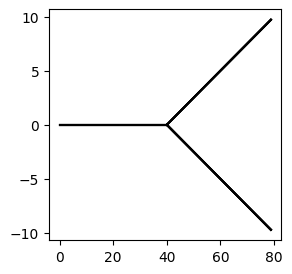

In [997]:
edges = [(0,1),(1,2),(2,3), (0,4),(4,5),(5,6),(6,7), (0,8),(8,9),(9,10),(10, 11)]
graph = nx.DiGraph()
graph.add_edges_from(edges)


module = from_graph(graph)
module.compute_xyz()
module.vis()

In [902]:
branch_idxs = nx.get_node_attributes(graph, "branch_index")
within_branch = np.array([(branch_idxs[i] == branch_idxs[j]) for i,j in graph.edges])
node_connections = np.stack([(i, j) for i,j in graph.edges])
pre,post = node_connections[~within_branch].T

In [872]:
idxs = pd.DataFrame({"cell_index": [0]*12, "branch_index":[0]*4+[1]*4+[2]*4, "comp_index": list(range(12))})

In [860]:
module.xyzr

[array([[nan, nan, nan, nan],
        [nan, nan, nan, nan]])]

In [757]:
def get_depth_first_branch_indexes(graph, nseg=4):
    branch_index = 0
    node_count = 0
    mapper = {}

    # depth first search to assign branch index
    for node in nx.dfs_preorder_nodes(graph):
        children = list(graph.successors(node))
        if len(children) > 1 or node_count == nseg:
            branch_index += 1
            node_count = 0
        mapper[node] = branch_index
        node_count += 1

    # reindex by enumerating number of unique branch indices
    recount = {old: new for new, old in enumerate(set(mapper.values()))}
    branch_index_mapper = {node_idx: {"branch_index": recount[branch_idx]} for node_idx, branch_idx in mapper.items()}
    return branch_index_mapper

def get_naive_branch_structure(graph, branch_len, nseg):
    if np.isnan(graph.nodes[0]["x"]):
        # assume each node == comp
        nx.set_node_attributes(graph, 0, "cell_index")
        graph.add_nodes_from({i: {"comp_index": i} for i in graph.nodes}.items())
        graph = index_branches_depth_first(graph)

        # ensure all branches have nseg segments
        # if branch has less than nseg segments, insert additional nodes between
        # between parent and child nodes
        for parent, child in graph.edges:
            parent_idx = graph.nodes[parent]["branch_index"]
            child_idx = graph.nodes[child]["branch_index"]
            if parent_idx == child_idx:
                continue
            if child_idx - parent_idx < nseg:
                for i in range(nseg - (child_idx - parent_idx)):
                    new_node = max(graph.nodes) + 1
                    graph.add_node(new_node, **{"branch_index": parent_idx})
                    graph.add_edge(parent, new_node)
                    parent = new_node 


    if "length" not in graph.nodes[0]:
        # assume max_branch_len/nseg == len
        graph.add_nodes_from((n, {"length": branch_len/nseg}) for n in graph.nodes)
    
    return graph

In [759]:
nx.set_node_attributes(graph, 0, "cell_index")
graph.add_nodes_from({i: {"comp_index": i} for i in graph.nodes}.items())

In [742]:
graph = get_naive_branch_structure(graph, 100, 4)

32

array([], dtype=int64)

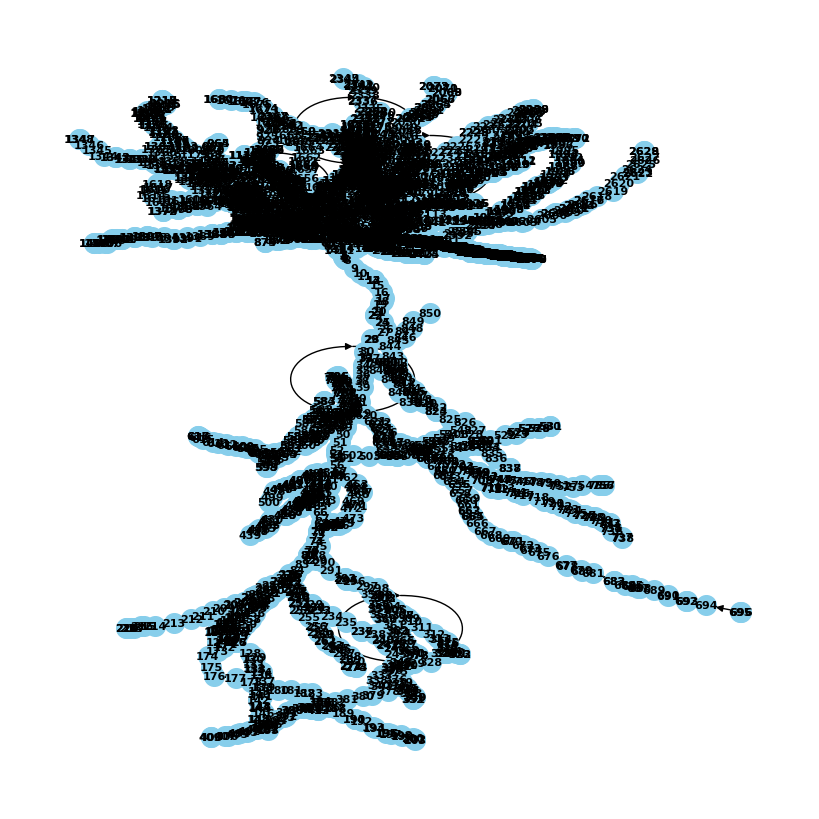

In [223]:
pos = {i: (n["x"], n["y"]) for i, n in graph.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [512]:
# df = pd.DataFrame((net.trainable_params,net.indices_set_by_trainables, []), index=["param", "index", "value"])
# df = df.T.explode("index").explode("index").reset_index(drop=True)
# split_col = df["param"].apply(lambda d: next(iter(d.items())))
# df[["param", "value"]] = pd.DataFrame(split_col.tolist())
# df = df.astype({"index": int, "value": float, "param": str})
# trainable_iter = {i: {k:np.array([v]) for i,(k,v) in group[["param", "value"]].iterrows()} for i,group in  df.groupby("index")}

In [479]:
# trainable_inds = np.unique(np.hstack(net.indices_set_by_trainables))
# trainable_params = {i:{} for i in trainable_inds}
# for i in trainable_inds:
#     for inds, params in zip(net.indices_set_by_trainables, net.trainable_params):
#         if i in inds.flatten():
#             trainable_params[i].update(params)
# trainable_iter = {k:{"trainables":v} for k,v in trainable_params.items()}
# module_graph.add_nodes_from(trainable_iter.items())

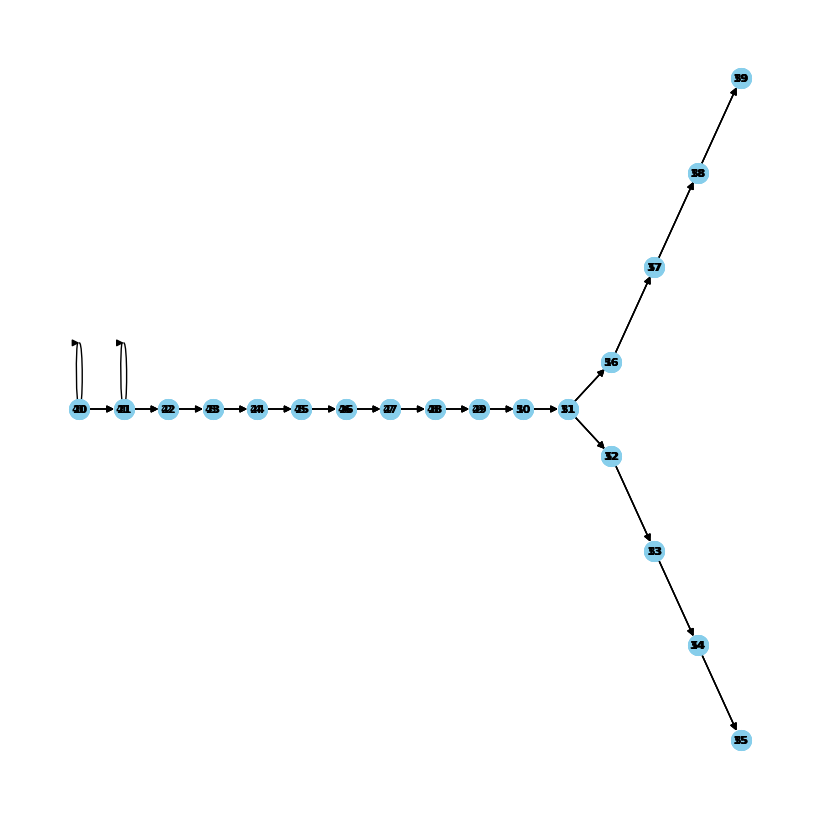

In [23]:
# plot the graph
pos = {i: (n["x"], n["y"]) for i, n in module_graph.nodes(data=True)} 
plt.figure(figsize=(8, 8))
nx.draw(module_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [ ]:
# # since the original xyzr is not known, one cannot know where xyzr was measured
# # and where it was interpolated. Therefore, original.xyzr and from_graph.xyzr
# # will probably differ.
# if "x" in nodes.columns:
#     # interpolate xyzr between first and last only
#     first_branch_inds = nodes.reset_index().groupby("branch_index").first()["index"].values
#     last_branch_inds = nodes.reset_index().groupby("branch_index").last()["index"].values
#     first_xyzr = nodes.loc[first_branch_inds][["x", "y", "z", "radius"]]
#     last_xyzr = nodes.loc[last_branch_inds][["x", "y", "z", "radius"]]
#     dl = last_xyzr[["x", "y", "z"]].values - first_xyzr[["x", "y", "z"]].values
#     first_xyzr[["x", "y", "z"]] = first_xyzr[["x", "y", "z"]]-1/2*dl/(module.nseg-1)
#     last_xyzr[["x", "y", "z"]] = last_xyzr[["x", "y", "z"]]+1/2*dl/(module.nseg-1)
#     xyzr = [np.vstack([first, last]) for first, last in zip(first_xyzr.values, last_xyzr.values)]

### Ideas:
- add a `groups` property
- show group membership in nodes
- make use to to_graph in plotting
- make use of from graph in swc import
- modules can be saved as graph, no need for pickle necessarily
- prevent untrainable stuff, like `Na` from being made trainable!
- Do we really want to enforce nsegs equal? is it required?